In [1]:
# Install required packages
!pip install tensorflow==2.12.0 tensorflow-addons==0.20.0 keras==2.12.0
!pip install typeguard==2.13.3 inflect==6.0.2
!pip install visualkeras
!pip install numpy==1.23.5

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2

In [4]:
# GPU configuration
!nvidia-smi

Tue Oct  1 05:40:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Define labels and image size
labels = ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould']
img_size = 32

In [6]:
# Data loading function
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
# Load and preprocess data
data_dir = get_data("/content/drive/Shareddrives/For_Research_S/MLD24/MLD24")

<ipython-input-6-f9261e232503>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
X = []
Y = []


for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)

In [9]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4737, 32, 32, 3) - y_train shape: (4737,)
x_val shape: (1041, 32, 32, 3) - y_val shape: (1041,)
x_test shape: (642, 32, 32, 3) - y_test shape: (642,)


In [10]:
import tensorflow_addons as tfa
from tensorflow import keras

input_shape = (32, 32, 3)
num_classes = 8  #########################################################
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
transformer_layers = 1
mlp_head_units = [2048, 1024]

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
def create_cnn_model(input_shape):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    return models.Model(inputs=base_model.input, outputs=x)


In [12]:
def create_simple_vit_model(cnn_output):
    num_patches = 6
    projection_dim = 64
    num_heads = 8 #####################################################

    inputs = layers.Input(shape=cnn_output)
    x = layers.Dense(num_patches * projection_dim)(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Single Transformer layer
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.Dense(projection_dim * 2, activation="gelu")(x)
    x = layers.Dense(projection_dim)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

In [13]:
def create_integrated_model():
    cnn_model = create_cnn_model(input_shape)
    cnn_output = cnn_model.output_shape[1]
    vit_model = create_simple_vit_model(cnn_output)

    inputs = layers.Input(shape=input_shape)
    x = cnn_model(inputs)
    outputs = vit_model(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()

    checkpoint_filepath = "/content/drive/MyDrive/Soursop/ViT_CNNmodel32.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,

        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7),


# stop learining as metric on validatopn stop increasing
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  verbose=1,
                                                  mode = 'auto')
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs= num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vitCNN_classifier = create_integrated_model()
vitCNN_history = run_experiment(vitCNN_classifier)

94668760/94668760 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 512)               24613888  
                                                                 
 model_1 (Functional)        (None, 8)                 347016    
                                                                 
Total params: 24,960,904
Trainable params: 24,915,464
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - 299s 8s/step - loss: 1.6504 - accuracy: 0.3882 - top-5-accuracy: 0.8478 - val_loss: 2.4832 - val_accuracy: 0.1306 - val_top-5-accuracy: 0.6244
Epoch 2/50
38/38 [==============================] - 288s 8s/step - loss: 0.7716 - accuracy: 0.7216 - top-5-accuracy: 0.9882 - val_loss: 2.1231 - val_accuracy: 0.3180 - val_top-5-accuracy: 0.8415
Epoch 3/50
38/38 [==============================] - 289s 8s/step - loss: 0.6002 - accuracy: 0.7792 - top-5-accuracy: 0.9962 - val_loss: 2.3246 - val_accuracy: 0.3766 - val_top-5-accuracy: 0.8184
Epoch 4/50
38/38 [==============================] - 289s 8s/step - loss: 0.4602 - accuracy: 0.8514 - top-5-accuracy: 0.9941 - val_loss: 3.4372 - val_accuracy: 0.3718 - val_top-5-accuracy: 0.8444
Epoch 5/50
38/38 [==============================] - 287s 8s/step - loss: 0.4000 - accuracy: 0.8822 - top-5-accuracy: 0.9937 - val_loss: 3.6147 - val_accuracy: 0.3593 - val_top-5-accuracy: 0.8963
Epoch 6/50
16/38 [===========>......

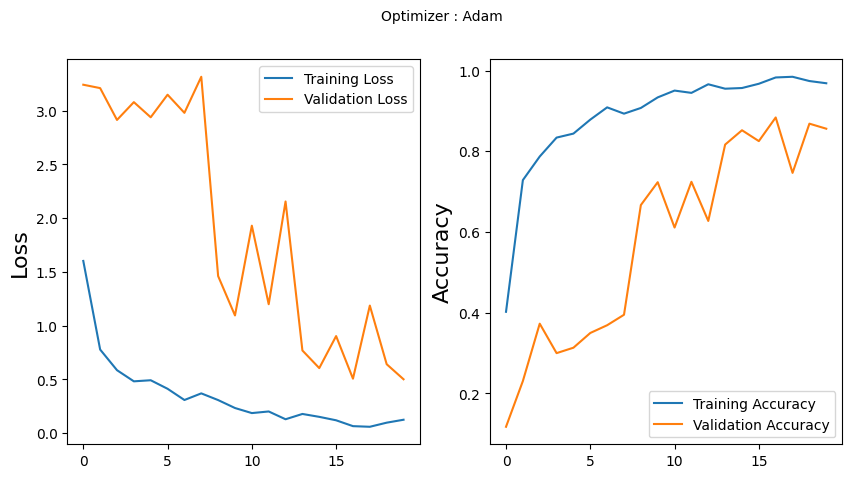

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vitCNN_history.history['loss'], label='Training Loss')
plt.plot(vitCNN_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vitCNN_history.history['accuracy'], label='Training Accuracy')
plt.plot(vitCNN_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
vit_predictions = vitCNN_classifier.predict(x_val)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

33/33 [==============================] - 4s 87ms/step


In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[132   0   5   0   1   0   0   0]
 [  0  95   0   0   2   0  15   4]
 [  0   0 140   0   0   0   0   0]
 [  0   0   1 132   0   0   0   0]
 [  0   0   1   0  96   1  20   2]
 [  0   0   2   0   7 124   0   0]
 [  0   0   0   0   0   0 119   0]
 [  0   0   6   0   0   0  54  82]]


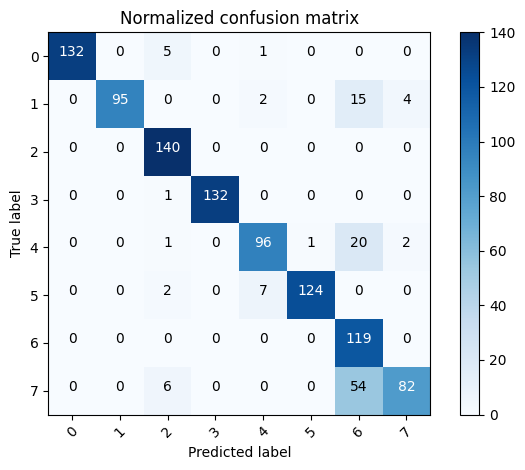

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_val, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6','7'], title='Normalized confusion matrix')
plt.show()

In [ ]:
report = classification_report(y_val, vit_y_pred, target_names=['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould'])
print(report)

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.96      0.98       138
Bacterial_Canker       1.00      0.82      0.90       116
  Cutting_Weevil       0.90      1.00      0.95       140
        Die_Back       1.00      0.99      1.00       133
      Gall_Midge       0.91      0.80      0.85       120
         Healthy       0.99      0.93      0.96       133
  Powdery_Mildew       0.57      1.00      0.73       119
     Sooty_Mould       0.93      0.58      0.71       142

        accuracy                           0.88      1041
       macro avg       0.91      0.88      0.88      1041
    weighted avg       0.92      0.88      0.89      1041



In [ ]:
vit_predictions = vitCNN_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6','7'], title='Normalized confusion matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [642, 1041]

In [ ]:
report = classification_report(y_test, vit_y_pred, target_names=['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould'])
print(report)